# Decision Trees on Amazon Reviews Dataset (Part II)


## Data Source: 
**The preprocessing step has produced final.sqlite file after doing the data preparation & cleaning.** The review text is now devoid of punctuations, HTML markups and stop words.

## Objective:
**To find optimal depth using GridSearchCV or iterated cross validation (ideal for one hyperparameter)** on standardized feature vectors obtained from BoW, tf-idf, W2V and tf-idf weighted W2V featurizations. 

**Find Precision, Recall, F1 Score, Confusion Matrix, Accuracy of 10-fold cross validation with GridSearch and Cross Validation with optimal Decision Tree model on vectorized input data, for BoW, tf-idf, W2V and tf-idf weighted W2V featurizations.** TPR, TNR, FPR and FNR is calculated for all. 


## At a glance:
Tail end data is taken after sorting the data, to conserve the timing info & time Series based cross validation is done, as it is time series data. **The optimal depth is found using GridSearchCV & Cross Validator, by searching for a range of depth 1-25.**

The Precision, Recall, F1 Score, Confusion Matrix, Accuracy metrics are found out for all 4 featurizations.<br><br>

# Preprocessed Data Loading

In [18]:
#loading libraries for LR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

#loading libraries for scikit learn, nlp, db, plot and matrix.
import sqlite3
import pdb
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import tree

from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# using the SQLite Table to read data.
con = sqlite3.connect('./final1.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
final = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con) 

print(final.head(2))

    index      Id   ProductId          UserId      ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL  shari zychinski   
1  138688  150506  0006641040  A2IW4PEEKO2R0U            Tracy   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     0                       0  positive   939340800   
1                     1                       1  positive  1194739200   

                                      Summary  \
0                   EVERY book is educational   
1  Love the book, miss the hard cover version   

                                                Text  \
0  this witty little book makes my son laugh at l...   
1  I grew up reading these Sendak books, and watc...   

                                         CleanedText  
0  b'witti littl book make son laugh loud recit c...  
1  b'grew read sendak book watch realli rosi movi...  




# Random Sampling & Time Based Slicing

In [19]:
# To randomly sample the data and sort based on time before doing train/ test split.
# The slicing into train & test data is done thereafter.

num_points = 40000

# used to format headings 
bold = '\033[1m'
end = '\033[0m'

# you can use random_state for reproducibility
# sampled_final = final.sample(n=num_points, random_state=2)

#Sorting data according to Time in ascending order
sorted_final = final.sort_values('Time', axis=0, 
                ascending=True, inplace=False, kind='quicksort', na_position='first')

selected_final = sorted_final.tail(num_points)

# fetching the outcome class 
y = selected_final['Score'] 

def class2num(response):
    if (response == 'positive'):
        return 1
    else:
        return 0

y_bin = list(map(class2num, y))

X_train, X_test, y_train, y_test = train_test_split(
            selected_final, y_bin, test_size=0.3, random_state=42)


# Custom Defined Functions

2 user defined functions are written to 

    a) GridSearchCV for Optimal Depth Estimation

    b) Compute DT Classifier Performance Metrics
    

## a) GridSearchCV for Optimal Depth Estimation

In [20]:
# source: https://chrisalbon.com/machine_learning/
# model_selection/hyperparameter_tuning_using_random_search/
# some parts of the below code are from the above link.

# Part of Decision tree code is taken from here.
# https://towardsdatascience.com/random-useful-scikit-learn-methods-a032f78e1ec3

# Cross Validation using GridSearchCV

import numpy 
import math
from scipy.stats import uniform
import matplotlib.pyplot as plt 
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import scipy

def gridRandomCV(X_train_vect, X_test_vect, genCloud = False, title_cf=''):
    
    # empty list that will hold cv scores
    cv_scores = []
    
    # Hyperparameters
    depth_range = range(1, 25)
    param_grid = dict(max_depth=depth_range)
    
    # to do time_series based CV, as it is time series data.
    tscv = TimeSeriesSplit(n_splits=10)
    
    # perform 10-fold cross validation
    for d in depth_range:

        dt = tree.DecisionTreeClassifier(max_depth=d)
        
        scores = cross_val_score(dt, 
                        X_train_vect, y_train, cv=tscv, scoring='accuracy')
        cv_scores.append(scores.mean())
        print('Accuracy at iteration = %d is %f.' %(d, scores.mean()))

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    print('\nMinimum error is at %f.' % MSE.index(min(MSE)))
    # determining best k
    optimal_d = depth_range[MSE.index(min(MSE))]
    print('\nThe optimal depth is %d.' % optimal_d)

    plt.figure()
    plt.title('Cross Validation Plot: Depth vs CV Error')
    plt.plot(depth_range, MSE)
    plt.show()
    
    # Enable this to do cross validation using nGridSearchCV
    
    #     dt_grid = genCV(tree.DecisionTreeClassifier(), param_grid, "grid")
    #     # Fit grid search 
    #     dt_grid.fit(X=X_train_vect, y=y_train)

    #     print("**Grid search results**")
    #     print("Best Training Accuracy:\t", dt_grid.best_score_)
    #     print("Best Parameters:\t", dt_grid.best_params_)
    #     print("Best Estimator:\t", dt_grid.best_estimator_)
    #     print("CV Results:\t", dt_grid.cv_results_)
    #     print("CV Results:\t", dt_grid.cv_results_.keys())
    #     means = dt_grid.cv_results_['mean_test_score']


    #     optimal_d = dt_grid.cv_results_[
    #                     'params'][means.argmax()].get('max_depth')
    #     print('\nGridSearchCV: Optimal Max Depth:', optimal_d)
    
    optimal_clf = tree.DecisionTreeClassifier(max_depth=optimal_d)
    optimal_clf.fit(X_train_vect, y_train)
    
    compute_metrics(optimal_clf, X_test_vect, 
                        title_cf="Confusion Matrix: GridSearchCV")
    
    if genCloud:
        return optimal_clf
    

## b) Compute DT Classifier Performance Metrics

In [21]:
# ========================== LR with alpha = optimal_alpha ============================
#To compute the performance metrics of DT classifier 

import seaborn as sn
from sklearn.metrics import *

def compute_metrics(dt_optimal, X_test_vect, title_cf="Confusion Matrix"):

    # predict the response
    pred = dt_optimal.predict(X_test_vect)

    print(bold + '\n\nMetric Analysis of DT Classifier' + end)
    
    # evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print('\nAccuracy \t= %f' % acc)
    
    precision = precision_score(y_test, pred) * 100
    print('Precision \t= %f' % precision)
    
    recall = recall_score(y_test, pred) * 100
    print('Recall \t\t= %f' % recall)
    
    f1score = f1_score(y_test, pred) * 100
    print('F1 Score \t= %f' % f1score)
    
    confusion = confusion_matrix(y_test, pred)
    print(bold + "\n\nConfusion Matrix" + end)
    
    plt.figure()
    plt.title(title_cf)
    df_cm = pd.DataFrame(confusion, range(2), range(2))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="d")# font size
    
    (tn, fp, fn, tp) = confusion.ravel()
    print("\nTrue Negatives = " + str(tn))
    print("True Positives = " + str(tp))
    print("False Negatives = " + str(fn))
    print("False Positives = " + str(fp))
    
    actual_positives = tp+fn
    actual_negatives = tn+fp
    print("\nTotal Actual Positives = " + str(actual_positives))
    print("Total Actual Negatives = " + str(actual_negatives))
    
    print("\nTrue Positive Rate(TPR) = " + str(round(tp/actual_positives, 2)))
    print("True Negative Rate(TNR) = " + str(round(tn/actual_negatives, 2)))
    print("False Positive Rate(FPR) = " + str(round(fp/actual_negatives, 2)))
    print("False Negative Rate(FNR) = " + str(round(fn/actual_positives, 2)))
    

In [22]:
# taken word cloud src from here:
# https://stackoverflow.com/questions/43043437/wordcloud-python-with-generate-from-frequencies
# modified for creating the dictionary of importance.

from wordcloud import WordCloud
    
def generateCloud(clf, vect):
    
    clf.fit(X_train_vect, y_train)
    
    feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = vect.get_feature_names(),
                                    columns=['importance']).sort_values(
                                             'importance',ascending=False)
    
    # remove features with importance = 0
    feature_importances = feature_importances.loc[
                            ~(feature_importances==0).all(axis=1)]

    # create the word cloud with feature importance as the scaling factor
    wordcloud = WordCloud(width=2200,height=1200, 
                  max_words=2000,relative_scaling=1,
                  normalize_plurals=False).generate_from_frequencies(
                                dict(feature_importances)['importance'])
    
    plt.figure(figsize =[16, 12])
    plt.title('Most Important Features in Amazon Reviews')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


# BoW

BoW will result in a **sparse matrix with huge number of features** as it creates a feature for each unique word in the review.

For Binary BoW feature representation, CountVectorizer is declared as float, as the values can take non-integer values on further processing. 



1) Grid Search CV using DT on BoW
Accuracy at iteration = 1 is 0.834813.
Accuracy at iteration = 2 is 0.839568.
Accuracy at iteration = 3 is 0.842161.
Accuracy at iteration = 4 is 0.843497.
Accuracy at iteration = 5 is 0.844244.
Accuracy at iteration = 6 is 0.845226.
Accuracy at iteration = 7 is 0.845226.
Accuracy at iteration = 8 is 0.846365.
Accuracy at iteration = 9 is 0.846248.
Accuracy at iteration = 10 is 0.846090.
Accuracy at iteration = 11 is 0.845580.
Accuracy at iteration = 12 is 0.845697.
Accuracy at iteration = 13 is 0.845619.
Accuracy at iteration = 14 is 0.845226.
Accuracy at iteration = 15 is 0.845383.
Accuracy at iteration = 16 is 0.844951.
Accuracy at iteration = 17 is 0.846208.
Accuracy at iteration = 18 is 0.845069.
Accuracy at iteration = 19 is 0.846837.
Accuracy at iteration = 20 is 0.847583.
Accuracy at iteration = 21 is 0.846719.
Accuracy at iteration = 22 is 0.847073.
Accuracy at iteration = 23 is 0.846994.
Accuracy at iteration = 24 is 0.844322.

Minimum erro

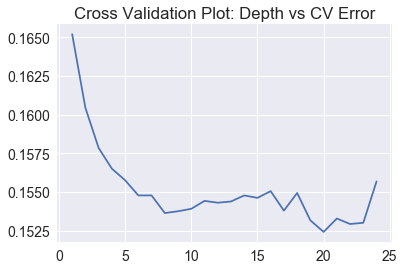



Metric Analysis of DT Classifier

Accuracy 	= 85.416667
Precision 	= 87.656923
Recall 		= 95.957468
F1 Score 	= 91.619577


Confusion Matrix

True Negatives = 684
True Positives = 9566
False Negatives = 403
False Positives = 1347

Total Actual Positives = 9969
Total Actual Negatives = 2031

True Positive Rate(TPR) = 0.96
True Negative Rate(TNR) = 0.34
False Positive Rate(FPR) = 0.66
False Negative Rate(FNR) = 0.04


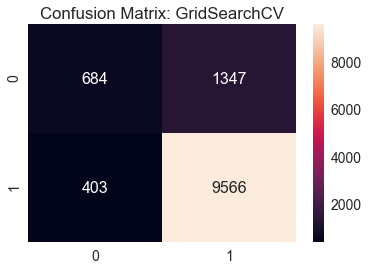

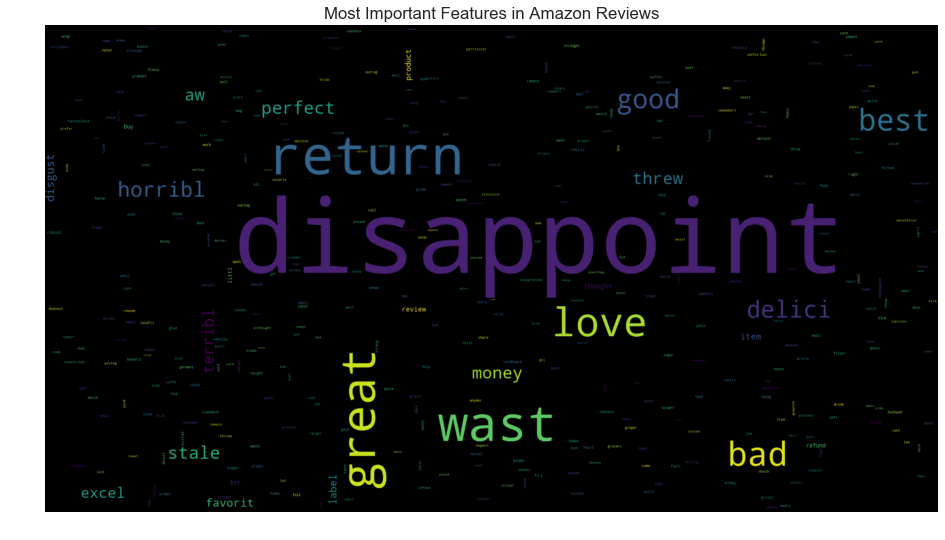

In [23]:
# BoW Featurisation, Standardisation, Grid Search and Random Search, 
# Impact of Sparsity on increasing lambda, Perturbation test to remove 
# multicollinear features, Find top n words using weight vector.

# from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
# from sklearn.preprocessing import StandardScaler

#BoW
count_vect = CountVectorizer(dtype="float") #in scikit-learn
X_train_vect = count_vect.fit_transform(X_train['CleanedText'].values)
X_train_vect.get_shape()

#BoW Test
X_test_vect = count_vect.transform(X_test['CleanedText'].values)

# Standardisation is not required for DTs

print(bold + "\n\n1) Grid Search CV using DT on BoW"+ end)

# Do both grid Search and Random Search. 
# The function computes the performance metrics also
clf = gridRandomCV(X_train_vect, X_test_vect, genCloud=True)

generateCloud(clf, count_vect)




# tf-IDF 

**Sparse matrix generated from tf-IDF ** is fed in to GridSearch DT Cross Validator to find the optimal depth value. Performance metrics of optimal DT with tf-idf featurization is found.



1) Grid Search CV using DT
Accuracy at iteration = 1 is 0.834853.
Accuracy at iteration = 2 is 0.840747.
Accuracy at iteration = 3 is 0.843065.
Accuracy at iteration = 4 is 0.844322.
Accuracy at iteration = 5 is 0.845776.
Accuracy at iteration = 6 is 0.845658.
Accuracy at iteration = 7 is 0.846640.
Accuracy at iteration = 8 is 0.847741.
Accuracy at iteration = 9 is 0.848527.
Accuracy at iteration = 10 is 0.848016.
Accuracy at iteration = 11 is 0.848173.
Accuracy at iteration = 12 is 0.847426.
Accuracy at iteration = 13 is 0.846798.
Accuracy at iteration = 14 is 0.846523.
Accuracy at iteration = 15 is 0.846916.
Accuracy at iteration = 16 is 0.847308.
Accuracy at iteration = 17 is 0.846208.
Accuracy at iteration = 18 is 0.844990.
Accuracy at iteration = 19 is 0.843811.
Accuracy at iteration = 20 is 0.844322.
Accuracy at iteration = 21 is 0.843811.
Accuracy at iteration = 22 is 0.843536.
Accuracy at iteration = 23 is 0.844008.
Accuracy at iteration = 24 is 0.843026.

Minimum error is at

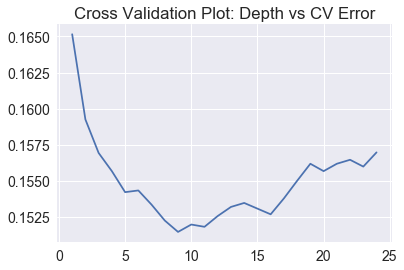



Metric Analysis of DT Classifier

Accuracy 	= 85.191667
Precision 	= 86.525771
Recall 		= 97.331728
F1 Score 	= 91.611198


Confusion Matrix

True Negatives = 520
True Positives = 9703
False Negatives = 266
False Positives = 1511

Total Actual Positives = 9969
Total Actual Negatives = 2031

True Positive Rate(TPR) = 0.97
True Negative Rate(TNR) = 0.26
False Positive Rate(FPR) = 0.74
False Negative Rate(FNR) = 0.03


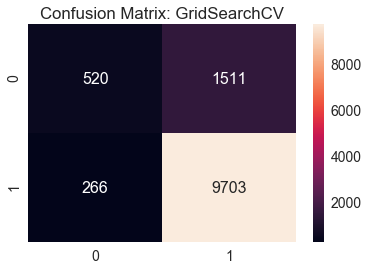

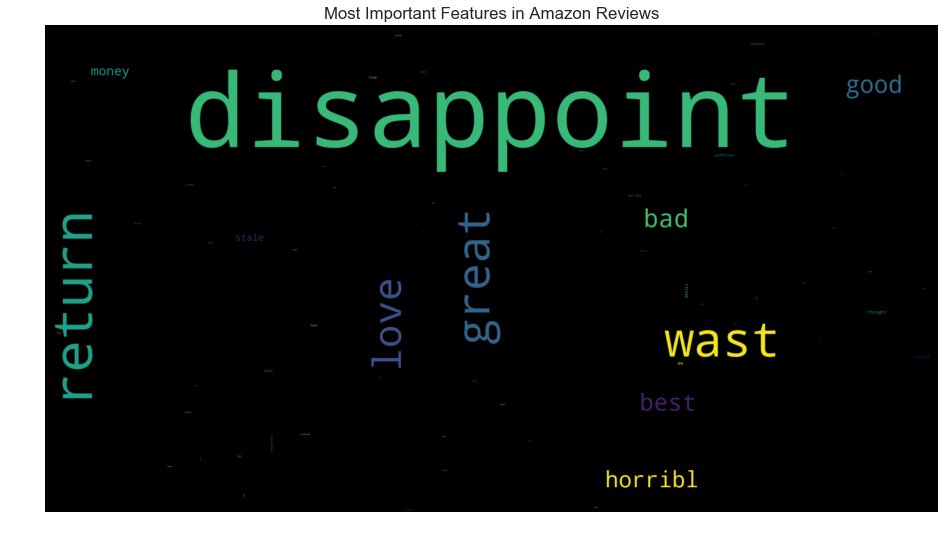

In [24]:
 
# TFID Featurisation, Standardisation, Grid Search and Random Search, 
# Perturbation test to remove multicollinear features, Find top n words.

from sklearn.random_projection import sparse_random_matrix
from sklearn.preprocessing import StandardScaler

# TFID
count_vect = TfidfVectorizer(dtype="float") #in scikit-learn
X_train_vect = count_vect.fit_transform(X_train['CleanedText'].values)
X_train_vect.get_shape()

# TFID Test
X_test_vect = count_vect.transform(X_test['CleanedText'].values)


print(bold + "\n\n1) Grid Search CV using DT"+ end)

# Do both grid Search and Random Search. 
# The function computes the performance metrics also
clf = gridRandomCV(X_train_vect, X_test_vect, genCloud=True)

generateCloud(clf, count_vect)

# Word2Vec

**Dense matrix generated from Word2Vec ** is fed in to GridSearch DT Cross Validator to find the optimal depth value. Performance metrics of optimal DT with W2V featurization is found. 


In [25]:
# Train your own Word2Vec model using your own text corpus
import gensim
import re

w2v_dim = 300

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

def trainW2V_model(reviewText):
    #select subset of points for fast execution
    i=0
    list_of_sent=[]

    for sent in reviewText:
        sent = str(sent, 'utf-8')
        filtered_sentence=[]
        sent=cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if(cleaned_words.isalpha()):    
                    filtered_sentence.append(cleaned_words.lower())
                else:
                    continue 
        list_of_sent.append(filtered_sentence)

    w2v_model=gensim.models.Word2Vec(list_of_sent,
                                     min_count=5,size=w2v_dim, workers=4) 
    
    return w2v_model

C:\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [26]:
# average Word2Vec
# compute average word2vec for each review.

def computeAvgW2V(w2vTrained_model, reviewText):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list

    for sent in reviewText: # for each review/sentence
        sent_vec = np.zeros(w2v_dim) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        sent = str(sent, 'utf-8')
        sent = re.sub("[^\w]", " ",  sent).split()

        for word in sent: # for each word in a review/sentence
            try:
                vec = w2vTrained_model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)

    return np.nan_to_num(sent_vectors)


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide




1) Grid Search CV using DT
Accuracy at iteration = 1 is 0.827741.
Accuracy at iteration = 2 is 0.829116.
Accuracy at iteration = 3 is 0.844283.
Accuracy at iteration = 4 is 0.842868.
Accuracy at iteration = 5 is 0.843654.
Accuracy at iteration = 6 is 0.842790.
Accuracy at iteration = 7 is 0.839489.
Accuracy at iteration = 8 is 0.837132.
Accuracy at iteration = 9 is 0.830216.
Accuracy at iteration = 10 is 0.825737.
Accuracy at iteration = 11 is 0.823654.
Accuracy at iteration = 12 is 0.820550.
Accuracy at iteration = 13 is 0.816071.
Accuracy at iteration = 14 is 0.812927.
Accuracy at iteration = 15 is 0.812495.
Accuracy at iteration = 16 is 0.811041.
Accuracy at iteration = 17 is 0.807819.
Accuracy at iteration = 18 is 0.807230.
Accuracy at iteration = 19 is 0.805147.
Accuracy at iteration = 20 is 0.805187.
Accuracy at iteration = 21 is 0.804361.
Accuracy at iteration = 22 is 0.802318.
Accuracy at iteration = 23 is 0.802122.
Accuracy at iteration = 24 is 0.801650.

Minimum error is at

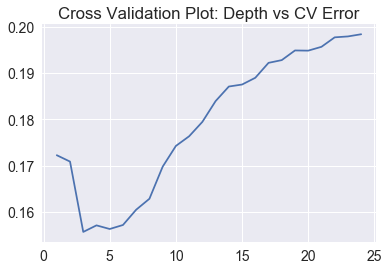



Metric Analysis of DT Classifier

Accuracy 	= 82.750000
Precision 	= 85.437416
Recall 		= 95.516100
F1 Score 	= 90.196078


Confusion Matrix

True Negatives = 408
True Positives = 9522
False Negatives = 447
False Positives = 1623

Total Actual Positives = 9969
Total Actual Negatives = 2031

True Positive Rate(TPR) = 0.96
True Negative Rate(TNR) = 0.2
False Positive Rate(FPR) = 0.8
False Negative Rate(FNR) = 0.04


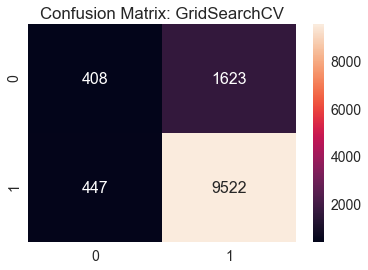

In [27]:
# W2V Main Function
# W2V Featurisation, Standardisation, Grid Search and Random Search, 
# Perturbation test to remove multicollinear features
# Can't find top n words using weight vector.

from sklearn.preprocessing import StandardScaler

# W2V Train
w2v_trainModel = trainW2V_model(X_train['CleanedText'].values)
X_train_vect = computeAvgW2V(w2v_trainModel, X_train['CleanedText'].values)

# W2V Test
w2v_testModel = trainW2V_model(X_test['CleanedText'].values)
X_test_vect = computeAvgW2V(w2v_testModel, X_test['CleanedText'].values)

# Standardisation is not required for DTs

print(bold + "\n\n1) Grid Search CV using DT"+ end)

# Do both grid Search and Random Search. 
# The function computes the performance metrics also
gridRandomCV(X_train_vect, X_test_vect)


# TF-ID Weighted W2V

In [28]:
# average Word2Vec
# compute average word2vec for each review.

def compute_tfidW2V(w2v_model, model_tf_idf, count_vect, reviewText):

    # the tfidf-w2v for each sentence/review is stored in this list
    tfidf_sent_vectors = []; 
    row=0; 
    
    # TF-IDF weighted Word2Vec
    tfidf_feats = count_vect.get_feature_names() # tfidf words/col-names

    # iterate for each review/sentence
    for sent in reviewText: 
        sent_vec = np.zeros(w2v_dim) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        sent = str(sent, 'utf-8')
        sent = re.sub("[^\w]", " ",  sent).split()
        
        for word in sent: # for each word in a review/sentence
            try:
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
                tfidf = model_tf_idf[row, tfidf_feats.index(word)]
                sent_vec += (vec * tfidf)
                weight_sum += tfidf
            except:
                pass
        sent_vec /= weight_sum

        tfidf_sent_vectors.append(sent_vec)
        row += 1

    return np.nan_to_num(tfidf_sent_vectors)


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide




1) Grid Search CV using DT
Accuracy at iteration = 1 is 0.827741.
Accuracy at iteration = 2 is 0.827741.
Accuracy at iteration = 3 is 0.833477.
Accuracy at iteration = 4 is 0.839646.
Accuracy at iteration = 5 is 0.839568.
Accuracy at iteration = 6 is 0.840629.
Accuracy at iteration = 7 is 0.833949.
Accuracy at iteration = 8 is 0.829470.
Accuracy at iteration = 9 is 0.821139.
Accuracy at iteration = 10 is 0.815835.
Accuracy at iteration = 11 is 0.809823.
Accuracy at iteration = 12 is 0.806405.
Accuracy at iteration = 13 is 0.804597.
Accuracy at iteration = 14 is 0.800157.
Accuracy at iteration = 15 is 0.794774.
Accuracy at iteration = 16 is 0.794224.
Accuracy at iteration = 17 is 0.796385.
Accuracy at iteration = 18 is 0.791238.
Accuracy at iteration = 19 is 0.790373.
Accuracy at iteration = 20 is 0.789155.
Accuracy at iteration = 21 is 0.786208.
Accuracy at iteration = 22 is 0.786680.
Accuracy at iteration = 23 is 0.786248.
Accuracy at iteration = 24 is 0.785422.

Minimum error is at

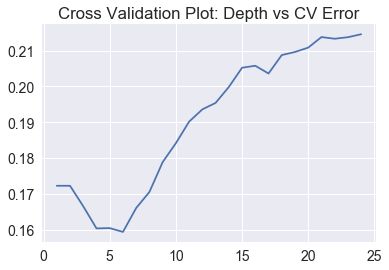



Metric Analysis of DT Classifier

Accuracy 	= 82.341667
Precision 	= 83.882942
Recall 		= 97.472164
F1 Score 	= 90.168422


Confusion Matrix

True Negatives = 164
True Positives = 9717
False Negatives = 252
False Positives = 1867

Total Actual Positives = 9969
Total Actual Negatives = 2031

True Positive Rate(TPR) = 0.97
True Negative Rate(TNR) = 0.08
False Positive Rate(FPR) = 0.92
False Negative Rate(FNR) = 0.03


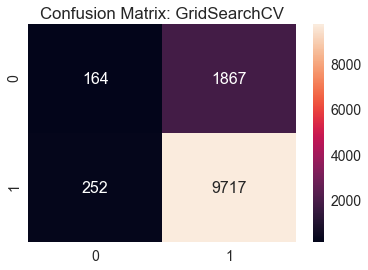

In [29]:
# tf-df weighted W2V Main Function
# tfidf and W2V Featurisation, Standardisation, Grid Search and Random Search, 
# Perturbation test to remove multicollinear features
# Can't find top n words using weight vector.

from sklearn.preprocessing import StandardScaler

# TFID
count_vect = TfidfVectorizer(dtype="float") #in scikit-learn
X_train_tfid_vect = count_vect.fit_transform(X_train['CleanedText'].values)

# TFID Test
X_test_tfid_vect = count_vect.transform(X_test['CleanedText'].values)


X_train_vect = compute_tfidW2V(w2v_trainModel, X_train_tfid_vect, 
                               count_vect, X_train['CleanedText'].values)
X_test_vect = compute_tfidW2V(w2v_testModel, X_test_tfid_vect, 
                              count_vect, X_test['CleanedText'].values)

# Standardisation is not required for DTs

print(bold + "\n\n1) Grid Search CV using DT"+ end)

# Do both grid Search and Random Search. 
# The function computes the performance metrics also
gridRandomCV(X_train_vect, X_test_vect)



# Summary Statistics


 Model | Method | Optimal Depth | Test Metric |
------------- |:--------:| -----:|:-----------------:|
**DT on BoW** | GridSearchCV| d = 20 | **Accuracy = 85.42, F1 Score = 91.62** <br>TPR = 0.96, TNR = 0.34, FPR = 0.66, FNR = 0.04|
**DT on tf-idf** | GridSearchCV| d = 9 | **Accuracy = 85.19, F1 Score = 91.61** <br>TPR = 0.97, TNR = 0.26, FPR = 0.74, FNR = 0.03|
**DT on W2V** | GridSearchCV| d = 3 | **Accuracy = 82.75, F1 Score = 90.2** <br>TPR = 0.96, TNR = 0.2, FPR = 0.8, FNR = 0.04|
**DT on tf-idf W2V** | GridSearchCV| d = 6 | **Accuracy = 82.34, F1 Score = 90.17** <br>TPR = 0.97, TNR = 0.08, FPR = 0.92, FNR = 0.03|

# Observations

1) The **GridSearchCV method and the 1-dimensional cross validation method with only depth as the hyperparameter, find out the same optimal depth** for the decision tree.

2) It has also been noticed that **the cross validation error is high when d = 1 and then it would slowly decrease.** After the tree grows to some **optimal depth, around 5-15, depending on the data, the CV error would increase.** This property has been observed in all the 4 featurizations, as seen in the CV error vs d plots, above. The point where the CV error falls to the lowest point is identified to find optimal depth.

3) Time-series based cross validation is used, as it is time series data.

4) **As the number of points increase, the time taken for BoW and tf-idf increases rapidly. But, W2V featurization is found to be stable**, as dimension of W2V vector is a constant.

5) The **best model** based on test metrics is found to be **DT on BoW**. But due to time constraints, **DT on W2V** may be more suitable when data is huge. BoW and tf-idf would create very high dimensional featurizations when the data is large.